In [14]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('colorspace')
library('extrafont')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

In [11]:
#get the listing dates of all 'EQ' and 'BE' series stocks
allStarts<-sqlQuery(lcon, "select symbol, min(time_stamp), max(time_stamp) from px_history 
                            where (series='eq' or series='be')
                            and time_stamp >= '2010-01-01' and time_stamp < '2017-06-01'
                            group by symbol")

allStarts[,2]<-as.Date(allStarts[,2])
allStarts[,3]<-as.Date(allStarts[,3])
#remove delisted
allStarts<-allStarts[allStarts[,3] == max(allStarts[,3]),]

#print(allStarts)

In [13]:
cumRets<-data.frame(SYMBOL="", D0=0.0, D5=0.0, D10=0.0, D20=0.0, D50=0.0, D100=0.0, stringsAsFactors = F)

for(i in 1:length(allStarts[,1])){
    sym<-toString(allStarts[i,1])
    
    retSeries<-sqlQuery(lcon, sprintf("select time_stamp, daily_return from RETURN_SERIES_ALL 
                                        where symbol='%s' and time_stamp >='%s'", sym, allStarts[i,2]))
    
    retXts<-xts(retSeries[,2], as.Date(retSeries[,1]))
    
    ###! there should be a better way to do this !###
    d5<-ifelse(length(retXts) >= 5, Return.cumulative(retXts[1:5]), NA)
    d10<-ifelse(length(retXts) >= 10, Return.cumulative(retXts[1:10]), NA)
    d20<-ifelse(length(retXts) >= 20, Return.cumulative(retXts[1:20]), NA)
    d50<-ifelse(length(retXts) >= 50, Return.cumulative(retXts[1:50]), NA)
    d100<-ifelse(length(retXts) >= 100, Return.cumulative(retXts[1:100]), NA)
    
    cumRets<-rbind(cumRets, c(sym, retXts[1]*100, d5*100, d10*100, d20*100, d50*100, d100*100))
}

cumRets<-cumRets[-1,]
#print(cumRets)

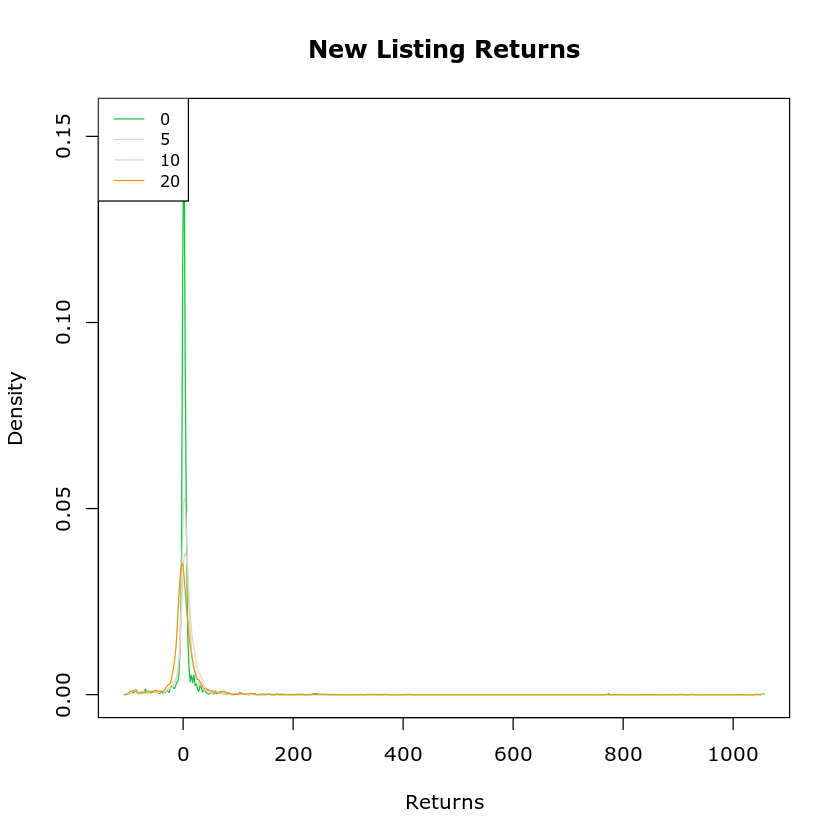

In [19]:
cumRets$D0<-as.numeric(cumRets$D0)
cumRets$D5<-as.numeric(cumRets$D5)
cumRets$D10<-as.numeric(cumRets$D10)
cumRets$D20<-as.numeric(cumRets$D20)
cumRets$D50<-as.numeric(cumRets$D50)
cumRets$D100<-as.numeric(cumRets$D100)

d0<-density(cumRets$D0, na.rm=T)
d5<-density(cumRets$D5, na.rm=T)
d10<-density(cumRets$D10, na.rm=T)
d20<-density(cumRets$D20, na.rm=T)
d50<-density(cumRets$D50, na.rm=T)
d100<-density(cumRets$D100, na.rm=T)

lineColors<-diverge_hcl(6, h = c(130, 43), c = 100, l = c(70, 90))

par(family='Verdana')
plot(range(d0$x, d5$x, d10$x, d20$x, d50$x, d100$x), range(d0$y, d5$y, d10$y, d20$y, d50$y, d100$y), type = "n", 
     ylab = "Density", xlab="Returns", main="New Listing Returns")

lines(d0, col=lineColors[1])
lines(d5, col=lineColors[2])
lines(d10, col=lineColors[3])
lines(d20, col=lineColors[4])
lines(d50, col=lineColors[5])
lines(d100, col=lineColors[6])
par(cex=0.8)
legend('topleft', legend=c('0', '5', '10', '20', '50', '100'), lty=1, col=lineColors)



In [20]:
cumRets[cumRets[,2] > 100,]

,SYMBOL,D0,D5,D10,D20,D50,D100
26,UNITEDTEA,171.0000,205.47372,125.15817,72.78963,41.05228,42.157500
27,KICL,242.6723,179.14222,225.94374,237.07276,204.83878,170.743530
77,BANARBEADS,237.2781,271.59762,321.89373,337.27825,243.78763,218.343817
236,CAREERP,102.6290,79.87089,62.33864,54.83867,14.79037,7.548151
357,BEARDSELL,105.0000,257.49990,353.75010,249.75009,218.25070,156.500745
533,WELINV,130.8227,180.76475,177.75193,254.80883,153.41885,72.885484
605,SUMMITSEC,107.1659,68.80382,30.76505,21.87517,25.75476,-13.631335
620,GSCLCEMENT,112.5000,157.49994,117.99976,95.99953,57.85441,56.798406
734,AGRITECH,241.2621,178.64063,116.99012,31.55321,-35.92254,-11.650658
789,DOLLAR,773.2278,845.85485,1014.08350,924.39868,NA,NA
